# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
train_transforms = transforms.Compose([
                                      transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

batch_size = 50

# Create training set and define training dataloader
## YOUR CODE HERE ##
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Sizes of the  datasets and loaders (both train and test)
print(len(trainset))
print(len(testset))

print(len(trainloader))
print(len(testloader))


Files already downloaded and verified
Files already downloaded and verified
50000
10000
1000
200


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
# Modifyed a bit to get different looks
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]

    fig, axes = plt.subplots(1, 5, figsize=(5, 3))  # Create a 1x5 grid of subplots

    for i, ax in enumerate(axes):
        image = images[i].numpy()
        image = image / 2 + 0.5  # un-normalize
        ax.imshow(np.transpose(image, (1, 2, 0)))
        ax.set_title(classes[labels[i]])  # Set the title as the corresponding class label
        ax.axis('off')  # Hide the axis

    plt.show()

image: tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.

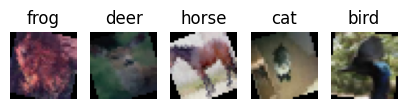

Test picture sample:


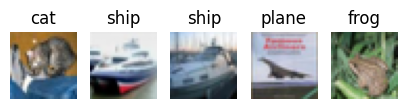

In [4]:
# Explore data
## YOUR CODE HERE ##

dataiter=iter(trainloader)
images,labels = next(dataiter)

print("image:", images)
print("labels:", labels)
print("shape of image:", images.shape)
print("shape of label:", labels.shape)

print("Train picture sample:")
show5(trainloader)
print("Test picture sample:")
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
## YOUR CODE HERE ##
from torch import nn, optim
import torch.nn.functional as F
# Simple FCNN
# Calculate the inputs: 32x32 pixels on 3 channels

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 10)

        # Dropout module with 0.2 drop probability --> to avoid the overfitting
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1) # Using log_softmax for the NLLLos

        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
## YOUR CODE HERE ##

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
## YOUR CODE HERE ##
# During the project only cpu was available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Plot the training loss (and validation loss/accuracy, if recorded).

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 70%, great work!
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [8]:
## YOUR CODE HERE ##
epochs = 20
model.to(device)

train_losses, test_losses, test_accuracies = [], [], []
for e in range(epochs):


    train_loss = 0
    for images, labels in trainloader:

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    else:
        test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval() # turn into eval mode
            for images, labels in testloader:

                images, labels = images.to(device), labels.to(device)

                log_ps = model(images)
                loss = criterion(log_ps, labels)

                test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        model.train() # turn back to train mode
        # Get mean loss to enable comparison between train and test sets
        acc_train_loss = train_loss / len(trainloader.dataset)
        acc_test_loss = test_loss / len(testloader.dataset)
        test_accuracy = test_correct / len(testloader.dataset)

        # At completion of epoch
        train_losses.append(acc_train_loss)
        test_losses.append(acc_test_loss)
        test_accuracies.append(test_accuracy)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(acc_train_loss),
              "Test Loss: {:.3f}.. ".format(acc_test_loss),
              "Test Accuracy: {:.3f}".format(test_accuracy))


Epoch: 1/20..  Training Loss: 0.042..  Test Loss: 0.040..  Test Accuracy: 0.326
Epoch: 2/20..  Training Loss: 0.038..  Test Loss: 0.037..  Test Accuracy: 0.365
Epoch: 3/20..  Training Loss: 0.036..  Test Loss: 0.035..  Test Accuracy: 0.393
Epoch: 4/20..  Training Loss: 0.034..  Test Loss: 0.034..  Test Accuracy: 0.413
Epoch: 5/20..  Training Loss: 0.033..  Test Loss: 0.033..  Test Accuracy: 0.425
Epoch: 6/20..  Training Loss: 0.033..  Test Loss: 0.032..  Test Accuracy: 0.434
Epoch: 7/20..  Training Loss: 0.032..  Test Loss: 0.032..  Test Accuracy: 0.442
Epoch: 8/20..  Training Loss: 0.031..  Test Loss: 0.031..  Test Accuracy: 0.449
Epoch: 9/20..  Training Loss: 0.031..  Test Loss: 0.031..  Test Accuracy: 0.453
Epoch: 10/20..  Training Loss: 0.031..  Test Loss: 0.030..  Test Accuracy: 0.463
Epoch: 11/20..  Training Loss: 0.030..  Test Loss: 0.030..  Test Accuracy: 0.466
Epoch: 12/20..  Training Loss: 0.030..  Test Loss: 0.030..  Test Accuracy: 0.475
Epoch: 13/20..  Training Loss: 0.029.

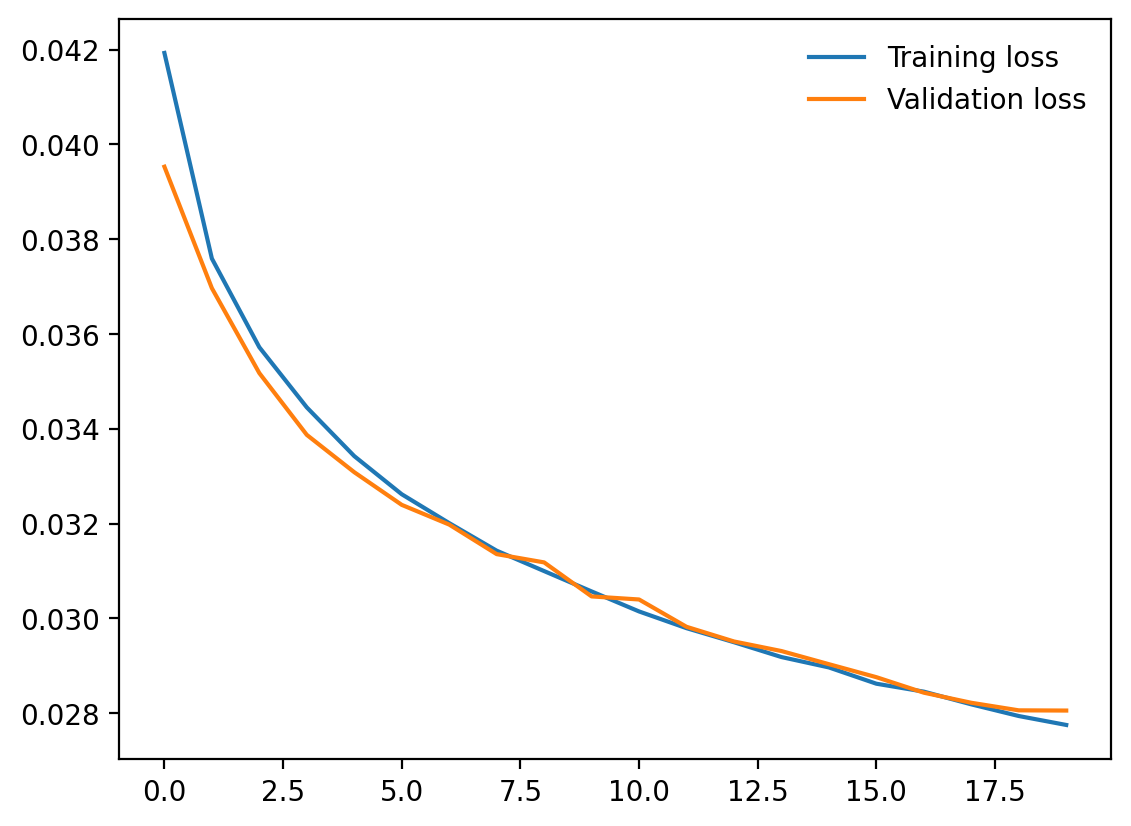

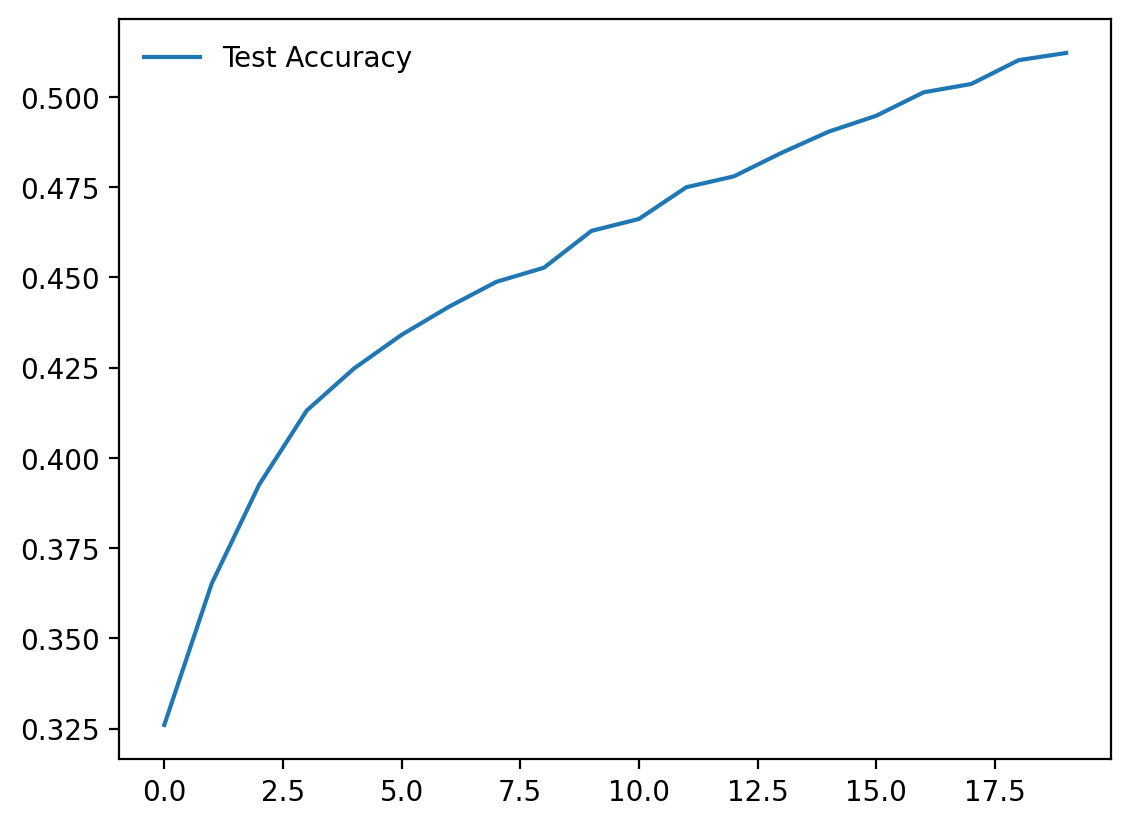

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

plt.figure(2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend(frameon=False)


## Saving your model
Using `torch.save`, save your model for future loading.

In [10]:
## YOUR CODE HERE ##
print("The model: \n\n", model, '\n')
PATH = './project_cifar_10.pth'
torch.save(model.state_dict(), PATH)

The model: 

 Classifier(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.



> Indented block

In our use case, we have built a basic Fully Connected Neural Network in a fairly easy manner, which has already achieved around 50% accuracy. However, there are numerous options for further development of this network to achieve higher accuracy, such as hyperparameter tuning, adding more layers, incorporating different layers (like convolution or pooling), trying pretrained models, etc. Considering this information and the fact that our company's profile involves self-driving cars, I believe it would be worthwhile to invest in acquiring the skillset for object detection in-house and develop our own solution.
